In [1]:
# basic imports
import pandas as pd
import numpy as np
import pydot
import math
import re
import matplotlib.pyplot as plt
from colorsys import hls_to_rgb

# causallearn imports
from causallearn.search.ConstraintBased.PC import pc

# pysat imports
from pysat.formula import CNF
from pysat.solvers import Glucose3

# sympy imports
from sympy.logic.boolalg import is_cnf, to_cnf

# qiskit imports
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.visualization import circuit_drawer

from qiskit import transpile
from qiskit.transpiler.passes import RemoveBarriers

/opt/anaconda3/envs/tesi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generate some synthetic data

In [2]:
# Generate data where X -> Y <- Z
X = np.random.uniform(size=10000)
eps = np.random.normal(size=10000)
delta = np.random.uniform(size=10000)
Y = -7*X + 0.5*delta
Z = 2*X + Y + eps

# Create DataFrame with named variables
data = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})

Run PC

In [3]:
# Store original column names
variable_names = list(data.columns)

g = pc(data.to_numpy())

Depth=1, working on node 2: 100%|██████████| 3/3 [00:00<00:00, 296.10it/s]


In [4]:
for i, node in enumerate(g.G.nodes):
    node.name = variable_names[i]

In [5]:
g.G.graph

array([[ 0, -1, -1],
       [-1,  0, -1],
       [-1, -1,  0]])

In [6]:
node_mapping = {node.name: index for index, node in enumerate(g.G.nodes)}
node_mapping


{'X': 0, 'Y': 1, 'Z': 2}

In [7]:
reversed_node_mapping = {index: node.name for index, node in enumerate(g.G.nodes)}
reversed_node_mapping

{0: 'X', 1: 'Y', 2: 'Z'}

Extract edges, since some of them are not order dependent

In [8]:
edges = []
indices = np.where(g.G.graph != 0)
processed_pairs = set()

for i, j in zip(indices[0], indices[1]):
    
    node_pair = frozenset([i.item(), j.item()])
    
    if node_pair in processed_pairs:
        continue
        
    if g.G.graph[i,j] == 1 and g.G.graph[j,i] == -1:
        edges.append({
            'from': reversed_node_mapping[i.item()],
            'to': reversed_node_mapping[j.item()],
            'type': "->"
        })
    
    elif g.G.graph[i,j] == -1 and g.G.graph[j,i] == -1:
        edges.append({
            'from': reversed_node_mapping[i.item()],
            'to': reversed_node_mapping[j.item()],
            'type': "--"
        })
        processed_pairs.add(node_pair) 
    
    elif g.G.graph[i,j] == 1 and g.G.graph[j,i] == 1:
        edges.append({
            'from': reversed_node_mapping[i.item()],
            'to': reversed_node_mapping[j.item()],
            'type': "<->"
        })
        processed_pairs.add(node_pair)

In [9]:
edges

[{'from': 'X', 'to': 'Y', 'type': '--'},
 {'from': 'X', 'to': 'Z', 'type': '--'},
 {'from': 'Y', 'to': 'Z', 'type': '--'}]

In [10]:
causal_dict = {}
for node1 in node_mapping:
    for node2 in node_mapping:
        for edge in ['direct']:
            causal_dict[(node1, node2, edge)] = len(causal_dict) + 1

In [11]:
causal_dict

{('X', 'X', 'direct'): 1,
 ('X', 'Y', 'direct'): 2,
 ('X', 'Z', 'direct'): 3,
 ('Y', 'X', 'direct'): 4,
 ('Y', 'Y', 'direct'): 5,
 ('Y', 'Z', 'direct'): 6,
 ('Z', 'X', 'direct'): 7,
 ('Z', 'Y', 'direct'): 8,
 ('Z', 'Z', 'direct'): 9}

Now we need to create logical Clauses from the edges. Logical clauses should be in CNF formula, which is a set of clauses is in or, but the clauses togeter are in and.

In [12]:
SATClauses = []
index = 0

for item in edges:
    
    if item['type'] == '->':
        # there MUST be a direct edge from node1 to node2 and NO direct edge from node2 to node1
        SATClauses.append([causal_dict[(item['from'], item['to'], 'direct')]])
        SATClauses.append([-causal_dict[(item['to'], item['from'], 'direct')]])
    elif item['type'] == '--':
        # there MUST be a direct edge from node1 to node2 OR a direct edge from node2 to node1
        SATClauses.append([causal_dict[(item['from'], item['to'], 'direct')], causal_dict[(item['to'], item['from'], 'direct')]])
    elif item['type'] == '<->':
        # there MUSTN'T be a direct edge from node1 to node2 AND a direct edge from node2 to node1
        SATClauses.append([-causal_dict[(item['from'], item['to'], 'direct')]])
        SATClauses.append([-causal_dict[(item['to'], item['from'], 'direct')]])

In [13]:
SATClauses

[[2, 4], [3, 7], [6, 8]]

In [14]:
# iterate through the clauses and count the number of variables
variable_set = set()
for clause in SATClauses:
    for var in clause:
        variable_set.add(abs(var))

In [15]:
new_var = list(range(1, len(variable_set) + 1))
new_var

[1, 2, 3, 4, 5, 6]

In [16]:
# create a mapping from old variable to new variable
cnf_variable_mapping = {}
for i, var in enumerate(variable_set):
    cnf_variable_mapping[var] = new_var[i]
    
cnf_variable_mapping

{2: 1, 3: 2, 4: 3, 6: 4, 7: 5, 8: 6}

In [17]:
new_cnf = []
for clause in SATClauses:
    new_clause = []
    for var in clause:
        new_var = cnf_variable_mapping[abs(var)]
        new_clause.append(new_var if var > 0 else -new_var)
    new_cnf.append(new_clause)

new_cnf

[[1, 3], [2, 5], [4, 6]]

In [18]:
formula = CNF(from_clauses=new_cnf)
formula

CNF(from_string='p cnf 6 3\n1 3 0\n2 5 0\n4 6 0')

In [19]:
solver = Glucose3()
solver.append_formula(formula)

In [20]:
isSat = solver.solve()
isSat

True

In [21]:
model = solver.get_model()
model

[1, 2, -3, 4, -5, -6]

In [22]:
# map back with cnf_variable_mapping
# reverse mapping
reverse_cnf_variable_mapping = {v: k for k, v in cnf_variable_mapping.items()}
reverse_cnf_variable_mapping

{1: 2, 2: 3, 3: 4, 4: 6, 5: 7, 6: 8}

In [23]:
temp = []
for item in model:
    temp.append(reverse_cnf_variable_mapping[abs(item)] if item > 0 else -reverse_cnf_variable_mapping[abs(item)])
model = temp
model

[2, 3, -4, 6, -7, -8]

In [24]:
# Create reverse mapping for interpretation
reversed_causal_dict = {v: k for k, v in causal_dict.items()}

In [25]:
causal_relationship = []

for item in model:
    absolute_value = abs(item)
    if absolute_value in reversed_causal_dict:
        node1, node2, edge = reversed_causal_dict[absolute_value]
        causal_relationship.append({
            "node1": node1,
            "node2": node2,
            "edge": edge,
            "exists": True if item > 0 else False
        })
causal_relationship

[{'node1': 'X', 'node2': 'Y', 'edge': 'direct', 'exists': True},
 {'node1': 'X', 'node2': 'Z', 'edge': 'direct', 'exists': True},
 {'node1': 'Y', 'node2': 'X', 'edge': 'direct', 'exists': False},
 {'node1': 'Y', 'node2': 'Z', 'edge': 'direct', 'exists': True},
 {'node1': 'Z', 'node2': 'X', 'edge': 'direct', 'exists': False},
 {'node1': 'Z', 'node2': 'Y', 'edge': 'direct', 'exists': False}]

In [26]:
solver.delete()

In [27]:
direct_causes = [rel for rel in causal_relationship if rel["edge"] == "direct" and rel["exists"]]

In [28]:
for rel in direct_causes:
    print(f"{rel['node1']} -> {rel['node2']}")

X -> Y
X -> Z
Y -> Z


In [29]:
# create a set of variables which will be the nodes
nodes = set()
for rel in causal_relationship:
    nodes.add(rel["node1"])
    nodes.add(rel["node2"])
graph = pydot.Dot("my_graph", graph_type="digraph")
for node in nodes:
    graph.add_node(pydot.Node(node))

for rel in causal_relationship:
    if rel["edge"] == "direct" and rel["exists"]:
        graph.add_edge(pydot.Edge(rel["node1"], rel["node2"], arrowhead=""))
    elif rel["edge"] == "latent" and rel["exists"]:
        graph.add_edge(pydot.Edge(rel["node2"], rel["node1"], arrowhead="normal"))

In [30]:
graph.write_png("output/output.png")

In [31]:
new_cnf

[[1, 3], [2, 5], [4, 6]]

In [32]:
new_mapping = list(range(1, len(variable_set) + 1))
new_mapping

[1, 2, 3, 4, 5, 6]

In [33]:
alphabet = "ABCDFGHIJKLMNOPQRSTUVWXYZ" # LOL, E is not a valid symbol for SYMPY... imagine how much did it took do discover this......
alphabet_dict = {}
for var in new_mapping:
    alphabet_dict.update({var: alphabet[var - 1]})

alphabet_dict

{1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'F', 6: 'G'}

In [34]:
# transform the formula into the LaTex formulation, since the previous code did that
# each number will correspond to a letter in the alphabet, A = 1, B = 2,...

latex_formula = ""
for clause in new_cnf:
    latex_formula += ("(")
    for var in clause:
        latex_formula += alphabet_dict[abs(var)] if var > 0 else "\neg" + alphabet_dict[abs(var)]
        if var != clause[-1]:
            latex_formula += (" \lor ")
    latex_formula += (")")
    if clause != new_cnf[-1]:
        latex_formula += (" \land ")

print(latex_formula)

(A \lor C) \land (B \lor F) \land (D \lor G)


<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
/var/folders/5d/lh100_9d5d7bwtxzmg0zcdmh0000gn/T/ipykernel_82520/4095721582.py:10: SyntaxWarning: invalid escape sequence '\l'
  latex_formula += (" \lor ")
/var/folders/5d/lh100_9d5d7bwtxzmg0zcdmh0000gn/T/ipykernel_82520/4095721582.py:13: SyntaxWarning: invalid escape sequence '\l'
  latex_formula += (" \land ")


In [61]:
formula = latex_formula
# print(formula)
# formula = "(A \lor B) \land (\neg A \lor C) \land (\neg B \lor \neg C) \land (A \lor C)"
print(formula)

(A \lor C) \land (B \lor F) \land (D \lor G)


In [36]:
# function to plot phases of the states
def plot_statevector_circles(statevector, figsize=(8, 8)):
    num_qubits = int(np.log2(len(statevector)))
    num_states = len(statevector)

    # Calculate grid dimensions
    grid_size = int(np.ceil(np.sqrt(num_states)))

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal')

    # Calculate radius for circles (adjust based on grid size)
    radius = 0.4 / grid_size

    # Iterate through basis states and position circles on the grid
    for i, amp in enumerate(statevector):
        row = grid_size - (i // grid_size) - 1
        col = i % grid_size

        x = col * 2 * radius + radius  # Center x-coordinate of the circle
        y = row * 2 * radius + radius  # Center y-coordinate of the circle

        phase = np.angle(amp)
        hue = (phase + np.pi) / (2 * np.pi)  # Map phase to hue (0 to 1)
        color = hls_to_rgb(hue, 0.5, 1)

        circle = plt.Circle((x, y), np.abs(amp) * radius, color=color, alpha=0.5)
        ax.add_artist(circle)

        ax.text(x, y, f"{bin(i)[2:].zfill(num_qubits)}", ha='center', va='center', fontsize=6)

        # Set plot limits (adjust as needed)
    ax.set_xlim([0, grid_size * 2 * radius])
    ax.set_ylim([0, grid_size * 2 * radius])
    ax.set_title("Statevector Circle Notation")
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks
    plt.show()

In [37]:
# we need a way to parse the boolean expressions as LaTex strings
def tokenize(formula: str):
    # Replace LaTeX sequences with simple tokens and trim white spaces
    formula = repr(formula.replace(r'\land', '&').replace(r'\lor', '|')).replace(r'\neg', '~').replace(r" ", "")
    # Now, you can split by parentheses and operators. For a naive approach:
    tokens = re.findall(r'[A-Za-z]+|~[A-Za-z]+|[\(\)&|]', formula)
    return tokens

# Function to count unique uppercase letters
def count_unique_uppercase(tokens):
    # Extract all variable names (e.g., A, B, C) and store only their uppercase part
    variables = set(token for token in tokens if token.isalpha() and token.isupper())
    return len(variables), variables

In [38]:
tokens = tokenize(formula)
token_string = " ".join(tokens)

# Count uppercase variables
unique_count, unique_variables = count_unique_uppercase(tokens)


sorted_variables = sorted(unique_variables)  # Ensures the order is consistent


var_dict = {var: idx for idx, var in enumerate(sorted_variables)}


was_cnf = is_cnf(token_string)

# if it is not a CNF convert it to a CNF with Sympy
if (not was_cnf):
    print("Not a CNF")
    token_string = to_cnf(token_string)

or_clauses = token_string.split("&")

# we count how many qubits we need. We sum the number of unique_count with the number of clauses
n = unique_count + len(or_clauses)

Some methods for Grover

In [39]:
def get_repr(qc, is_inv, clause, i):
    clause = clause.replace("(", "").replace(")", "").replace(" ", "")
    sub_clause = clause.split("|")
    first = False
    second = False
    if len(sub_clause[0]) == 2: first = True # means that the formula is notted
    if len(sub_clause[1]) == 2: second = True # same as above

    # look up positions
    clause = clause.replace("~", "")
    sub_clause = clause.split("|")
    pos1 = var_dict[sub_clause[0]]
    pos2 = var_dict[sub_clause[1]]
    # put notted synbols
    if first: qc.x(pos1)
    if second: qc.x(pos2)

    qc.x(pos1)
    qc.x(pos2)

    if is_inv:
        qc.x(i)

    qc.mcx([pos1, pos2], i)

    if not is_inv:
        qc.x(i)

    qc.x(pos1)
    qc.x(pos2)

    if first: qc.x(pos1)
    if second: qc.x(pos2)
    qc.barrier()

def oracle(qc):
    for i, clause in enumerate(or_clauses):
        get_repr(qc, False, clause, unique_count + i)

    qc.mcp(np.pi, list(range(unique_count,n-1)), n-1)
    qc.barrier()

    reversed_or_clauses = or_clauses[::-1]

    for clause in reversed_or_clauses:
        get_repr(qc, True, clause, unique_count + i)
        i -= 1

def diffuser(qc, n):
    qc.h(range(n))
    qc.x(range(n))
    qc.mcp(np.pi, list(range(n-1)), n - 1)
    qc.x(range(n))
    qc.h(range(n))
    qc.barrier()

def create_circuit(qc):
    oracle(qc)
    diffuser(qc, unique_count)


6


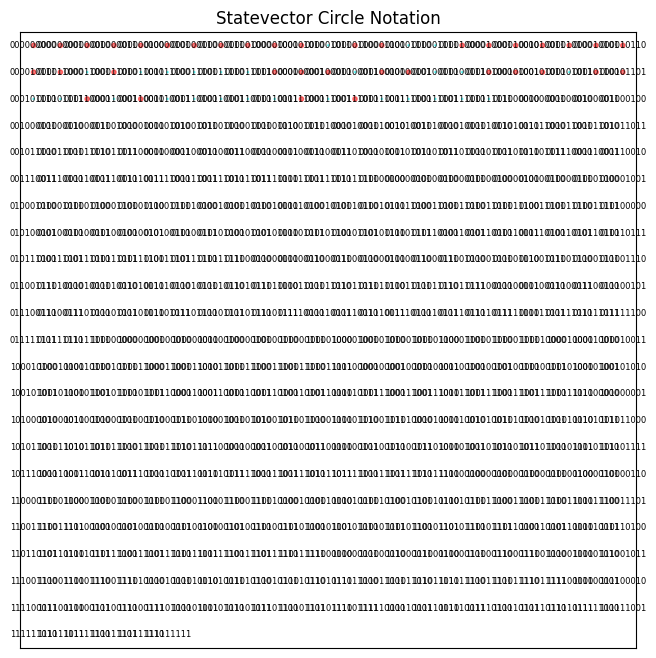

In [65]:
qc = QuantumCircuit(n)
create_circuit(qc)


# now we want to repeat the oracle and the diffuser sqrt(2^n) times
reps = round( np.pi/4 * math.sqrt( 2**unique_count ))

print(reps)

qc = QuantumCircuit(n)
qc.h(list(range(unique_count)))
for i in range(reps):
    create_circuit(qc)

# create statevector
statevector = Statevector(qc)
# plot statevector
plot_statevector_circles(statevector)


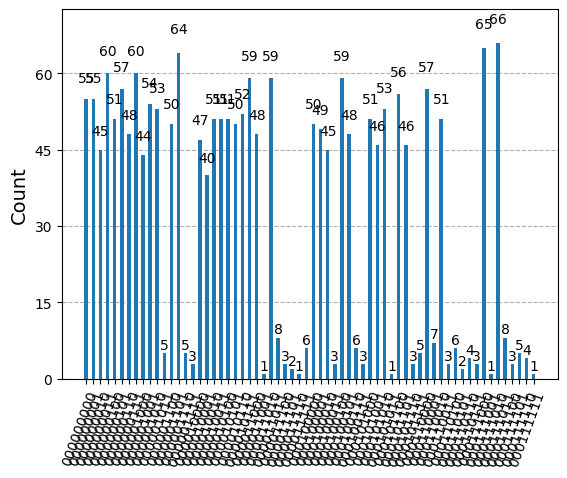

In [66]:

qc.measure_all()
result = Sampler().run([qc], shots=2048).result()[0]
co = result.data.meas.get_counts()

circuit_drawer(qc, output="mpl")

plot_histogram(co)

In [49]:
qc = RemoveBarriers()(qc)

print(qc.count_ops())

optimized_qc = transpile(qc, optimization_level=3)

print(optimized_qc.count_ops())

# this is the optimized circuit plot. It's a hige circuit, be aware of the dimensions of the image
# circuit_drawer(optimized_qc, output="mpl")

OrderedDict({'x': 336, 'h': 102, 'ccx': 48, 'measure': 36, 'mcphase': 16})
OrderedDict({'cx': 976, 'tdg': 336, 't': 237, 'p': 232, 'u2': 153, 'u3': 120, 'measure': 36, 'h': 19, 'crz': 16})


In [ ]:
# take the result from co

{'000000001': 28,
 '000010000': 30,
 '000100001': 47,
 '000001000': 34,
 '000000101': 45,
 '000110110': 21,
 '000001111': 22,
 '000011000': 40,
 '000011011': 18,
 '000010111': 44,
 '000110001': 21,
 '000011010': 38,
 '000010001': 45,
 '000110101': 18,
 '000110010': 41,
 '000101001': 38,
 '000001001': 40,
 '000101100': 43,
 '000100011': 16,
 '000011111': 21,
 '000110000': 28,
 '000010110': 37,
 '000110011': 28,
 '000001110': 24,
 '000100101': 37,
 '000100000': 39,
 '000000111': 55,
 '000100100': 39,
 '000000100': 36,
 '000101010': 37,
 '000011001': 20,
 '000010011': 36,
 '000001101': 43,
 '000111000': 43,
 '000000000': 48,
 '000010100': 41,
 '000010010': 50,
 '000011110': 28,
 '000100110': 17,
 '000101101': 54,
 '000100010': 35,
 '000001011': 21,
 '000001100': 41,
 '000101000': 42,
 '000000010': 46,
 '000111111': 18,
 '000111100': 25,
 '000011101': 18,
 '000111010': 42,
 '000111001': 24,
 '000010101': 31,
 '000001010': 44,
 '000101011': 21,
 '000111101': 22,
 '000110111': 26,
 '00010111